In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-13 12:32:15.127337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:32:15.131113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:32:15.131212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:32:15.131480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

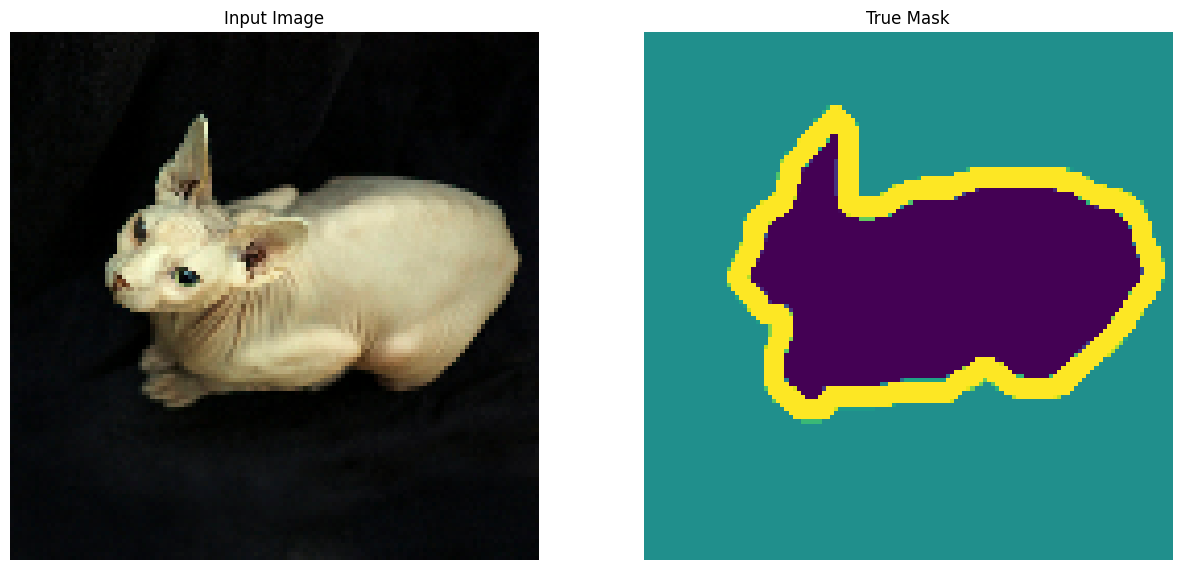

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [7]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])    
x = inputs  

# block 1
x = tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre1 = x

# block 2
x = tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre2 = x

# block 3
x = tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre3 = x

# block 4
x = tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre4 = x

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# upsampling
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre4])

# upsampling
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre3])

# upsampling
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre2])

# upsampling
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre1])

# upsampling
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(3, 3, padding='same')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 3)  1731        ['up_sampling2d_4[0][0]']        
                                                                                                  
Total params: 11,055,875
Trainable params: 11,051,011
Non-trainable params: 4,864
__________________________________________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-13 12:32:18.982158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-13 12:32:19.443434: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:32:19.443823: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:32:19.443834: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-13 12:32:19.444188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:32:19.444221: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

919/920 [============================>.] - ETA: 0s - loss: 0.7081 - accuracy: 0.6972

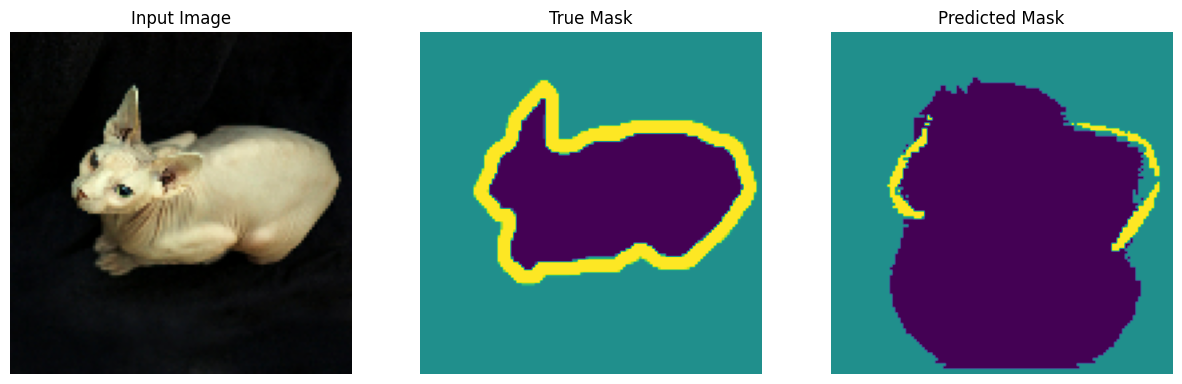


Sample Prediction after epoch 1

920/920 [==============================] - 22s 21ms/step - loss: 0.7081 - accuracy: 0.6972 - val_loss: 0.6578 - val_accuracy: 0.7382
Epoch 2/20
919/920 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.7579

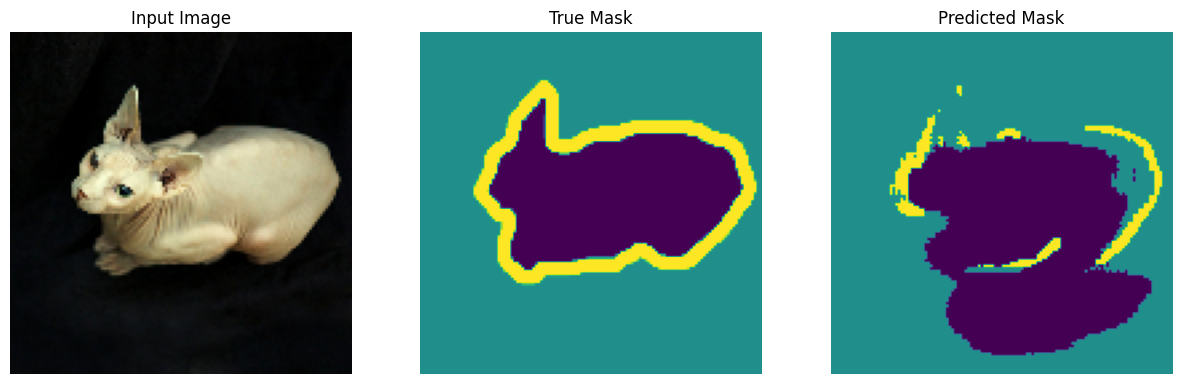


Sample Prediction after epoch 2

920/920 [==============================] - 19s 20ms/step - loss: 0.5858 - accuracy: 0.7579 - val_loss: 0.6229 - val_accuracy: 0.7511
Epoch 3/20
919/920 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.7825

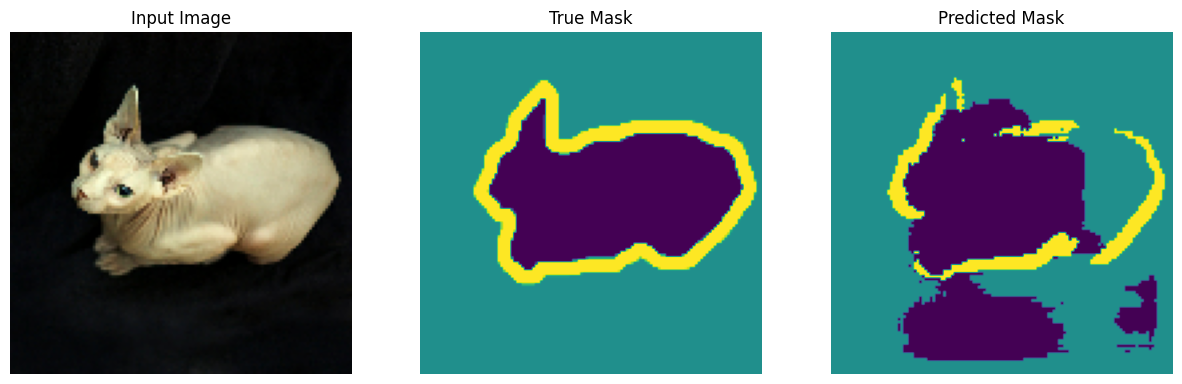


Sample Prediction after epoch 3

920/920 [==============================] - 19s 20ms/step - loss: 0.5316 - accuracy: 0.7824 - val_loss: 0.5789 - val_accuracy: 0.7729
Epoch 4/20
918/920 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.7973

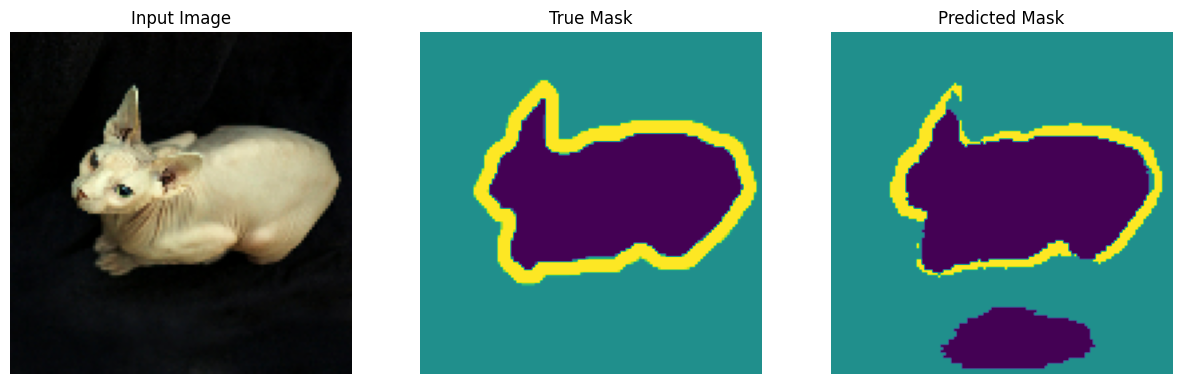


Sample Prediction after epoch 4

920/920 [==============================] - 19s 20ms/step - loss: 0.4969 - accuracy: 0.7973 - val_loss: 0.5548 - val_accuracy: 0.7785
Epoch 5/20
919/920 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8080

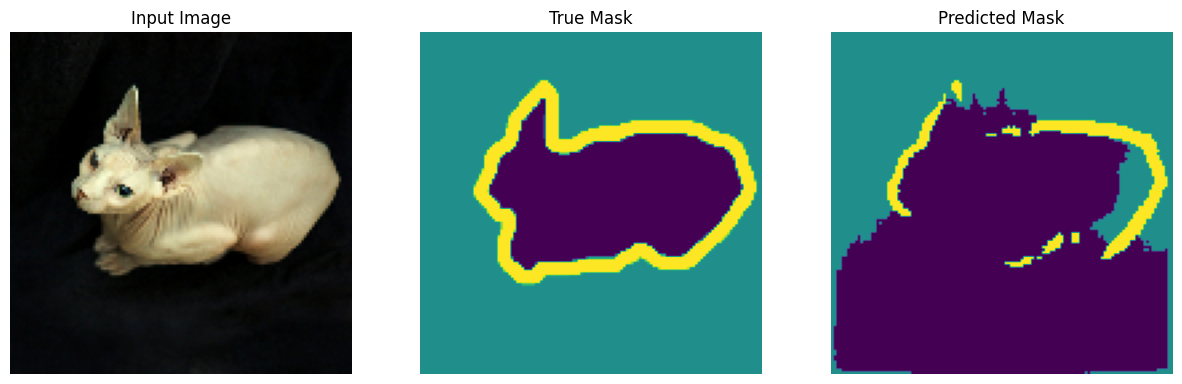


Sample Prediction after epoch 5

920/920 [==============================] - 19s 20ms/step - loss: 0.4692 - accuracy: 0.8081 - val_loss: 0.5380 - val_accuracy: 0.7825
Epoch 6/20
919/920 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8183

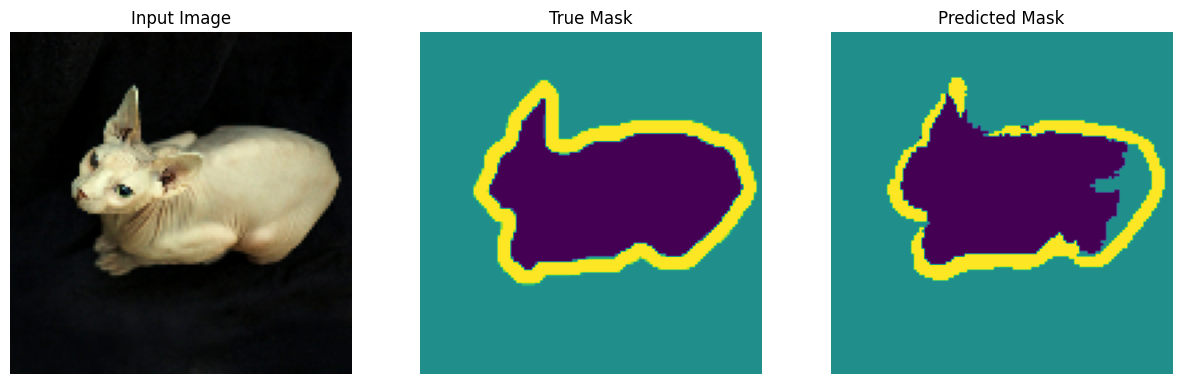


Sample Prediction after epoch 6

920/920 [==============================] - 19s 20ms/step - loss: 0.4460 - accuracy: 0.8183 - val_loss: 0.4848 - val_accuracy: 0.8102
Epoch 7/20
919/920 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8279

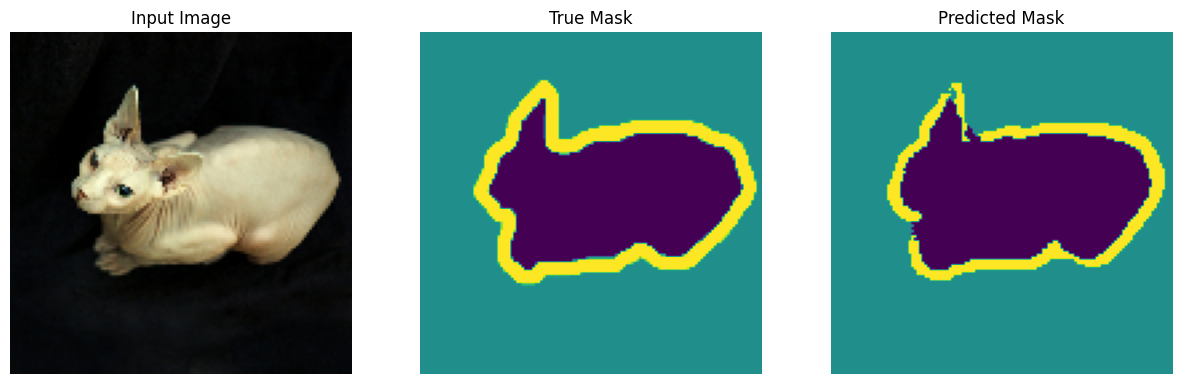


Sample Prediction after epoch 7

920/920 [==============================] - 19s 20ms/step - loss: 0.4198 - accuracy: 0.8279 - val_loss: 0.4386 - val_accuracy: 0.8224
Epoch 8/20
919/920 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8370

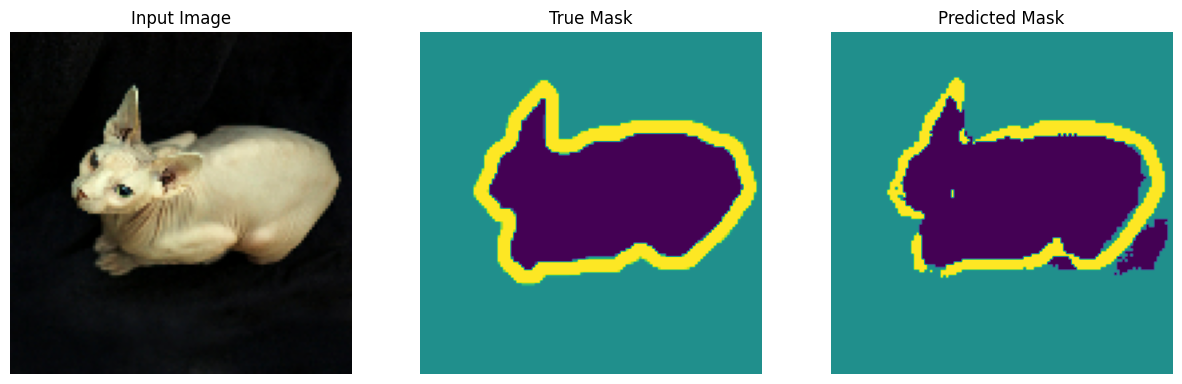


Sample Prediction after epoch 8

920/920 [==============================] - 19s 20ms/step - loss: 0.3969 - accuracy: 0.8370 - val_loss: 0.4487 - val_accuracy: 0.8171
Epoch 9/20
918/920 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8503

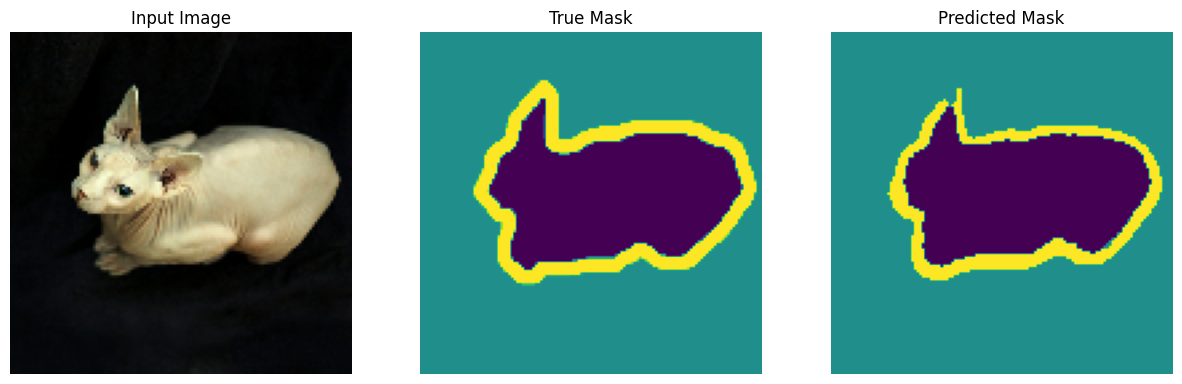


Sample Prediction after epoch 9

920/920 [==============================] - 19s 20ms/step - loss: 0.3642 - accuracy: 0.8503 - val_loss: 0.4398 - val_accuracy: 0.8236
Epoch 10/20
918/920 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8630

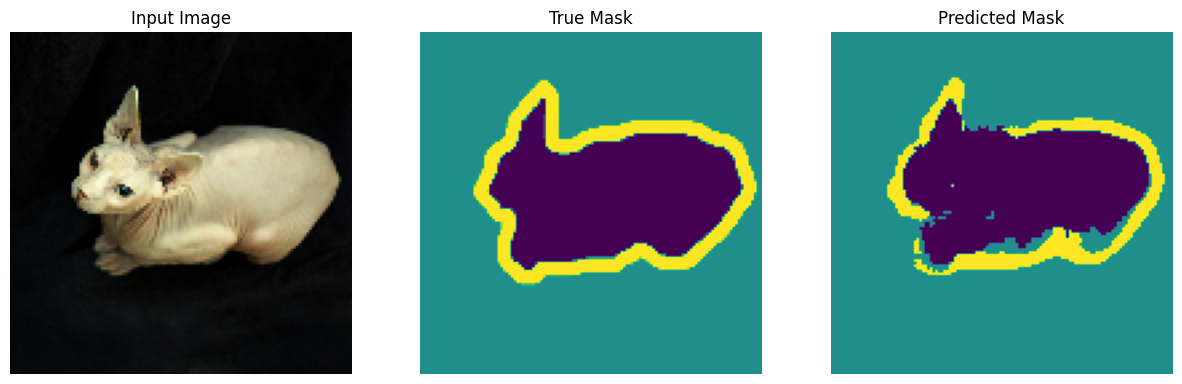


Sample Prediction after epoch 10

920/920 [==============================] - 19s 20ms/step - loss: 0.3327 - accuracy: 0.8630 - val_loss: 0.6669 - val_accuracy: 0.7494
Epoch 11/20
918/920 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8726

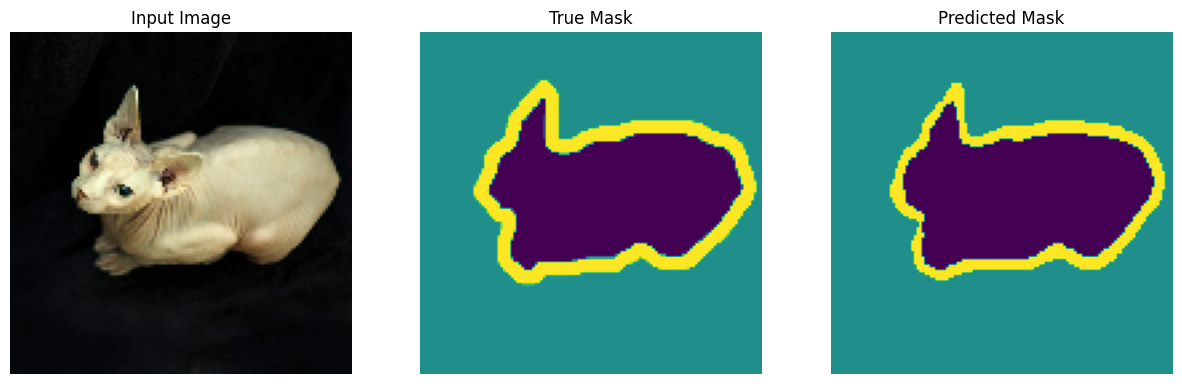


Sample Prediction after epoch 11

920/920 [==============================] - 19s 20ms/step - loss: 0.3074 - accuracy: 0.8726 - val_loss: 0.4621 - val_accuracy: 0.8278
Epoch 12/20
919/920 [============================>.] - ETA: 0s - loss: 0.2799 - accuracy: 0.8828

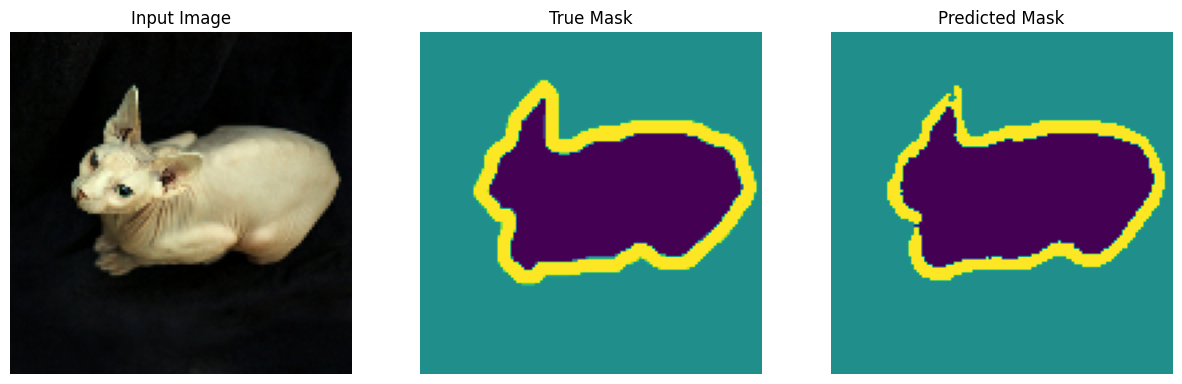


Sample Prediction after epoch 12

920/920 [==============================] - 19s 20ms/step - loss: 0.2799 - accuracy: 0.8828 - val_loss: 0.4349 - val_accuracy: 0.8352
Epoch 13/20
919/920 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.8902

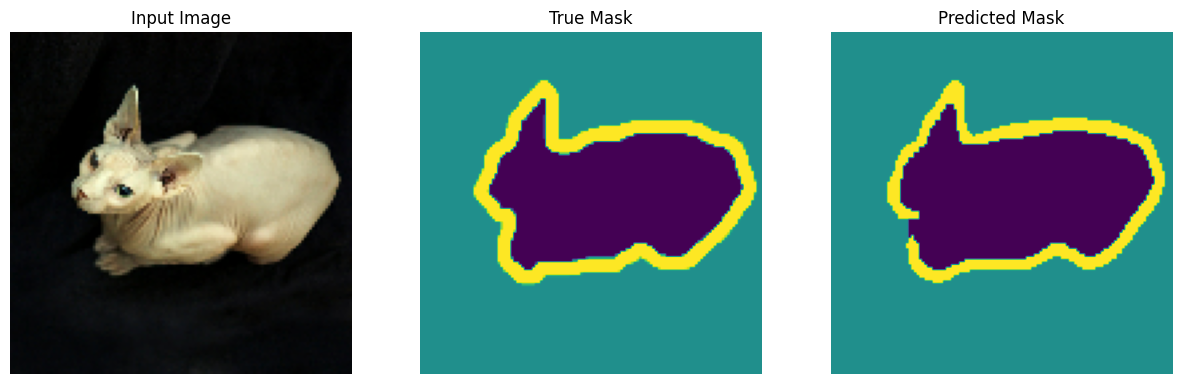


Sample Prediction after epoch 13

920/920 [==============================] - 19s 20ms/step - loss: 0.2597 - accuracy: 0.8902 - val_loss: 0.4702 - val_accuracy: 0.8273
Epoch 14/20
918/920 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.8982

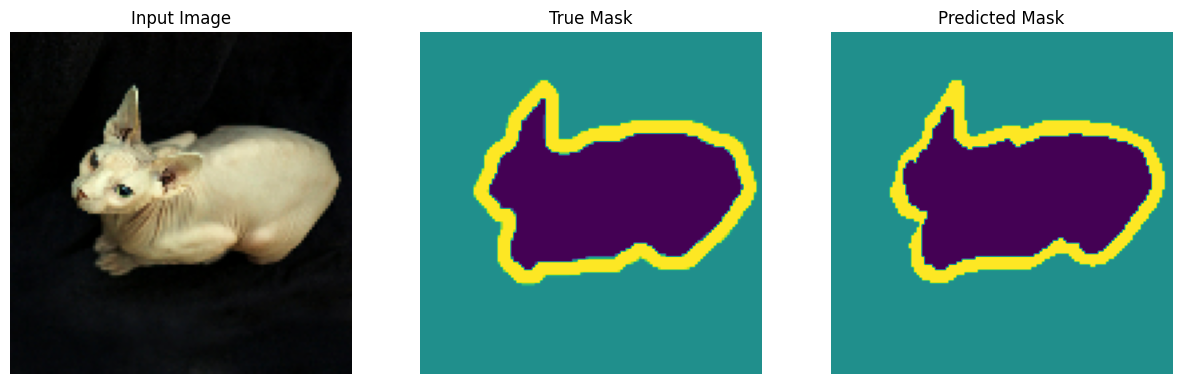


Sample Prediction after epoch 14

920/920 [==============================] - 19s 20ms/step - loss: 0.2387 - accuracy: 0.8982 - val_loss: 0.4509 - val_accuracy: 0.8325
Epoch 15/20
918/920 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9034

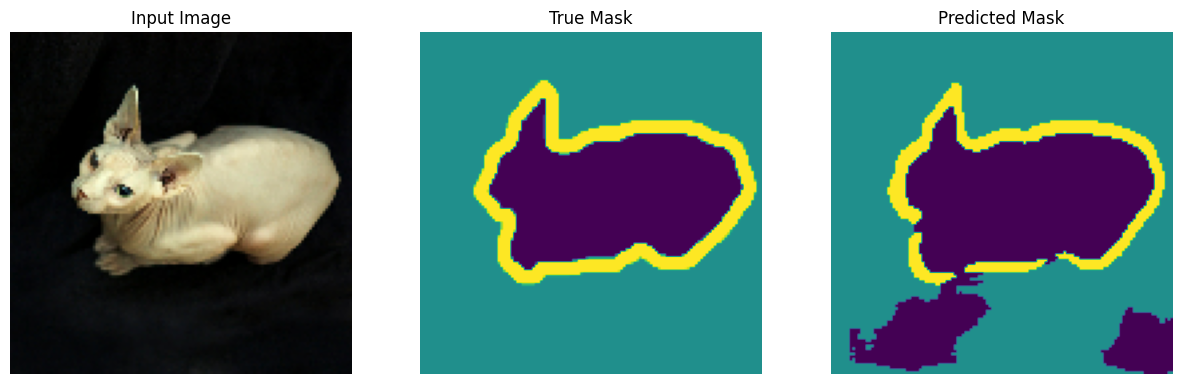


Sample Prediction after epoch 15

920/920 [==============================] - 19s 20ms/step - loss: 0.2255 - accuracy: 0.9034 - val_loss: 0.5301 - val_accuracy: 0.8187
Epoch 16/20
918/920 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9080

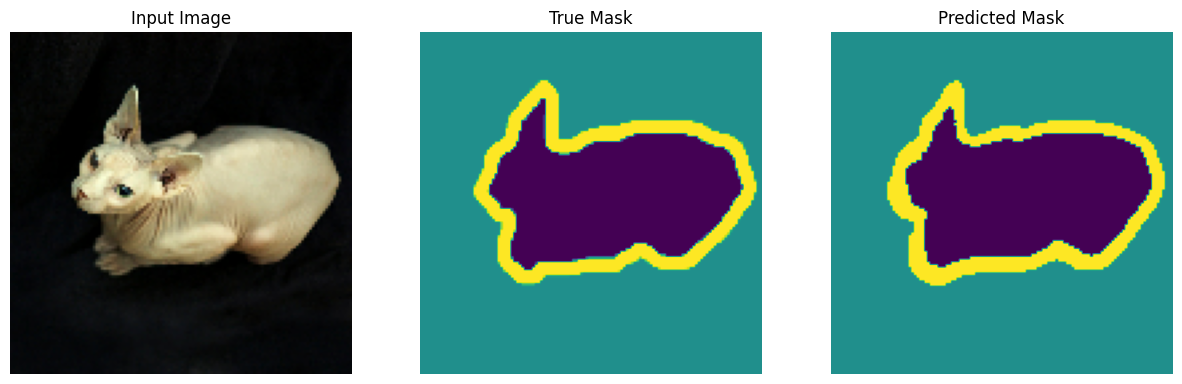


Sample Prediction after epoch 16

920/920 [==============================] - 19s 20ms/step - loss: 0.2115 - accuracy: 0.9081 - val_loss: 0.4552 - val_accuracy: 0.8385
Epoch 17/20
920/920 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9095

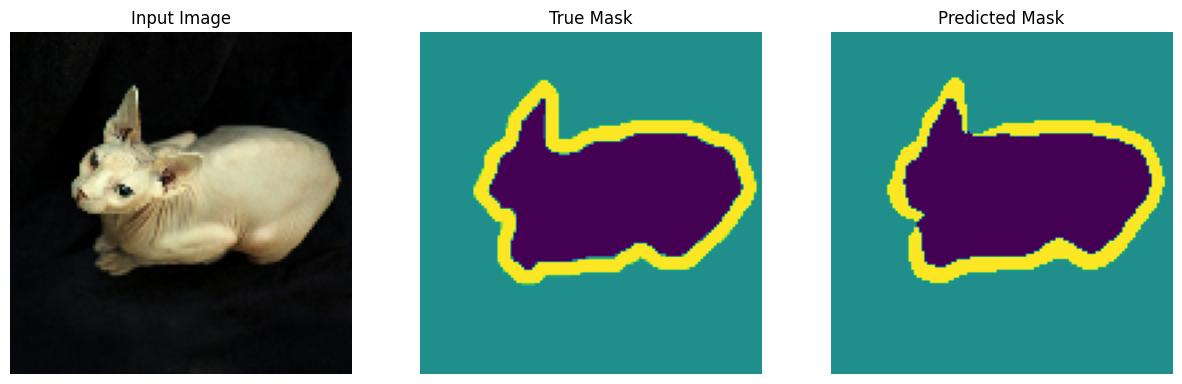


Sample Prediction after epoch 17

920/920 [==============================] - 19s 21ms/step - loss: 0.2081 - accuracy: 0.9095 - val_loss: 0.4967 - val_accuracy: 0.8355
Epoch 18/20
919/920 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9160

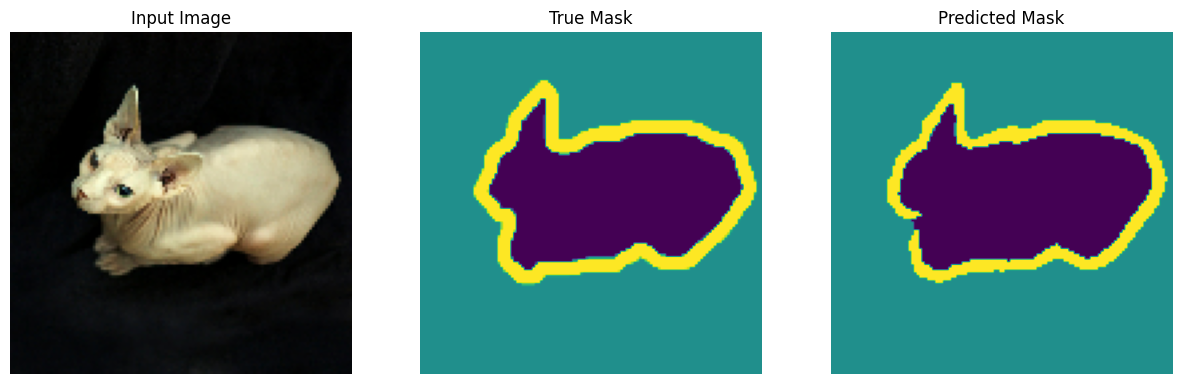


Sample Prediction after epoch 18

920/920 [==============================] - 18s 20ms/step - loss: 0.1911 - accuracy: 0.9160 - val_loss: 0.4728 - val_accuracy: 0.8246
Epoch 19/20
919/920 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9195

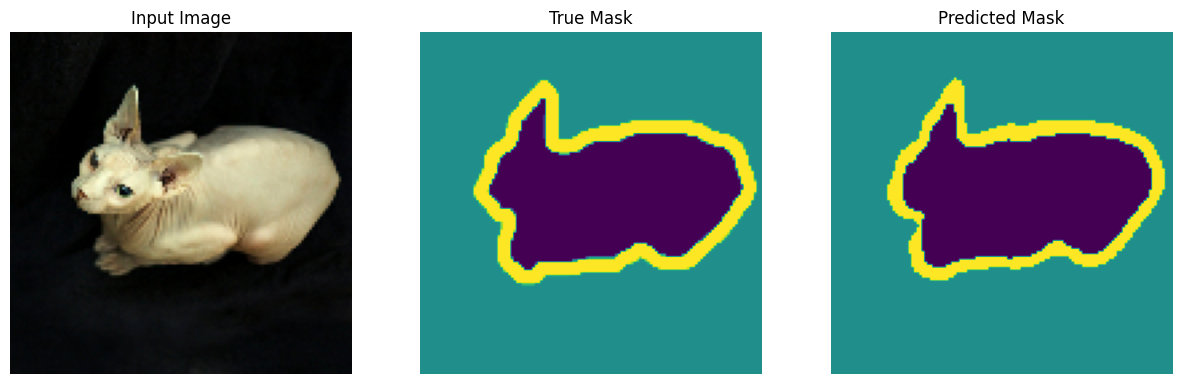


Sample Prediction after epoch 19

920/920 [==============================] - 18s 20ms/step - loss: 0.1816 - accuracy: 0.9195 - val_loss: 0.4525 - val_accuracy: 0.8438
Epoch 20/20
919/920 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9216

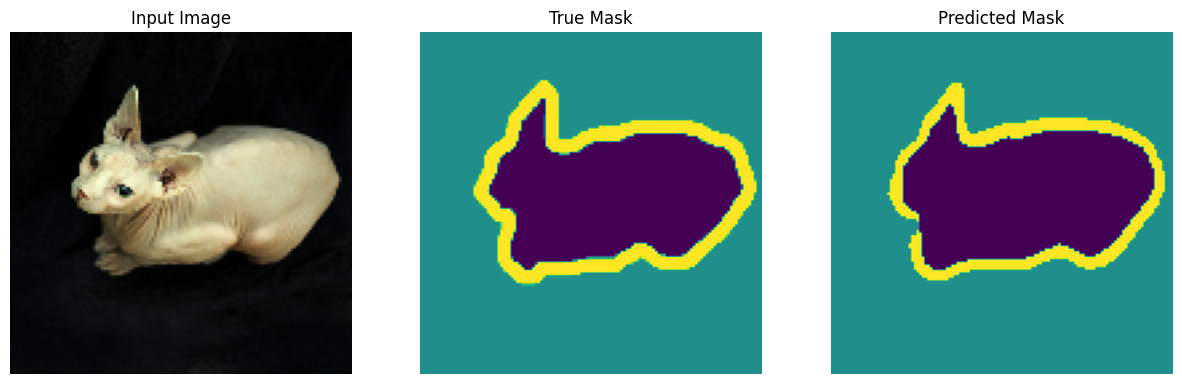


Sample Prediction after epoch 20

920/920 [==============================] - 18s 20ms/step - loss: 0.1767 - accuracy: 0.9216 - val_loss: 0.4916 - val_accuracy: 0.8397


In [9]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

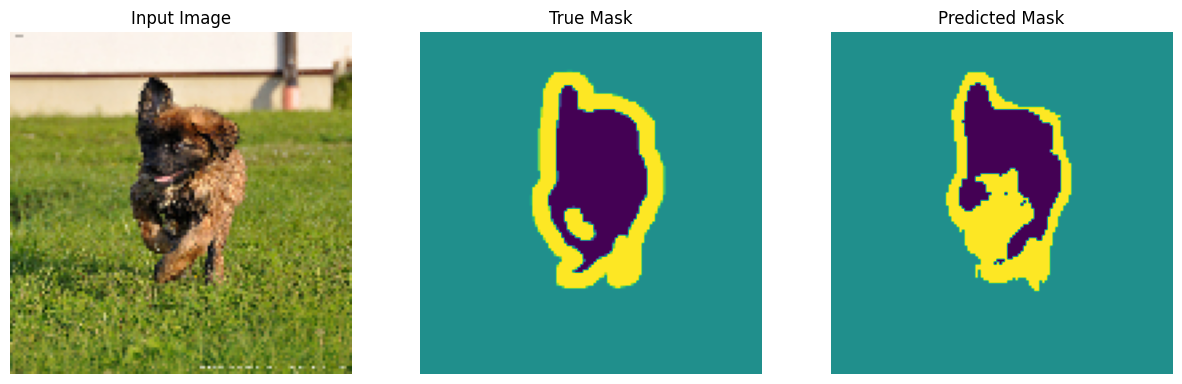

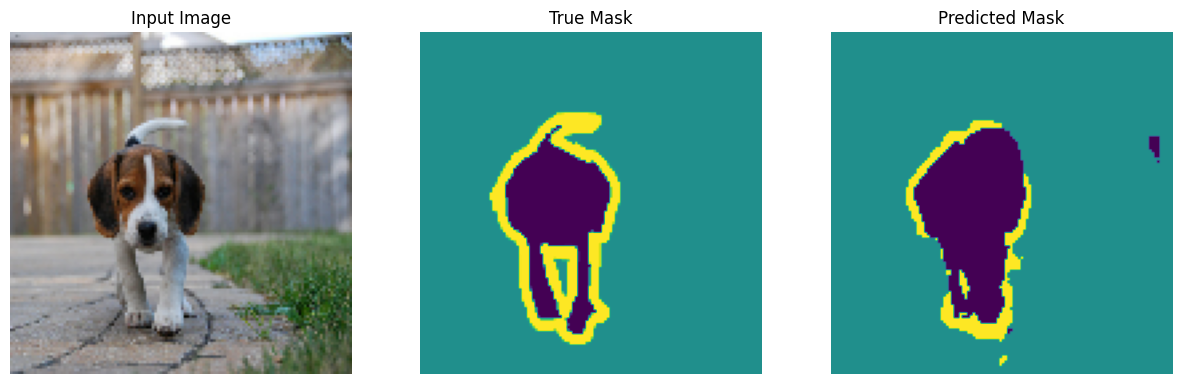

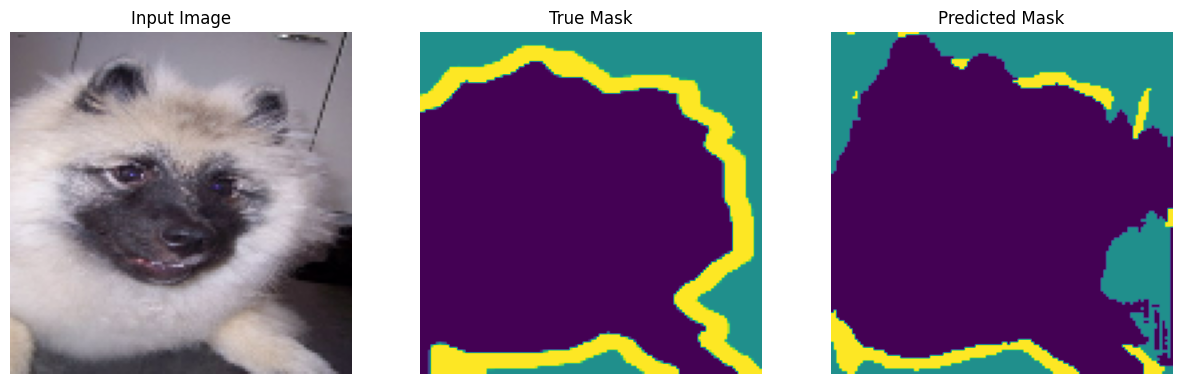

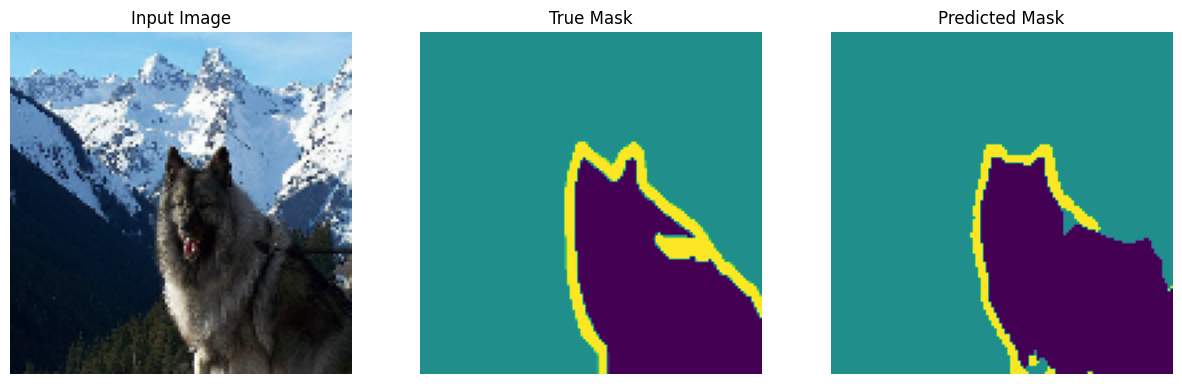

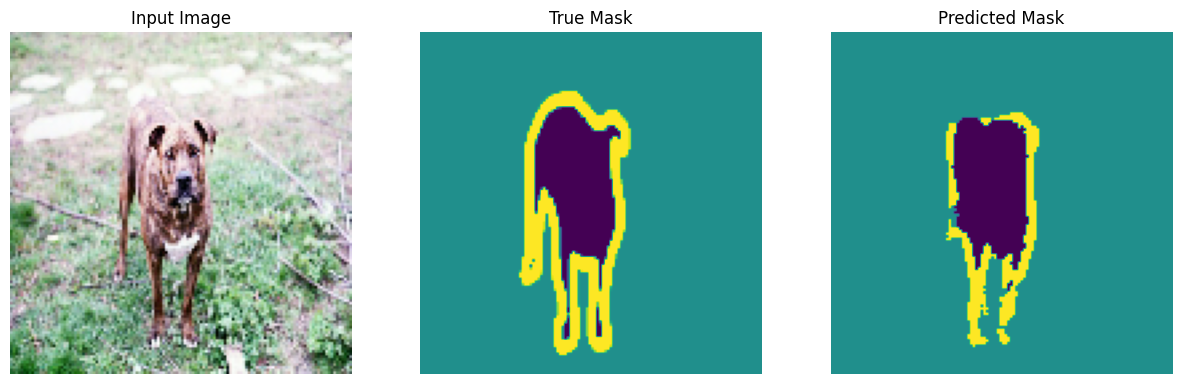

In [10]:
show_predictions(test_dataset, 5)